In [75]:
import time
import numpy as np
import torch
import jax
import jax.numpy as jnp
import cupy as cp
import matplotlib.pyplot as plt

def symmetrize(x):
    if isinstance(x, np.ndarray) or isinstance(x, cp.ndarray):
        if x.ndim == 2:
            return (x + x.T) / 2
        return (x + x.transpose(0, 2, 1)) / 2
    elif isinstance(x, torch.Tensor):
        if x.ndim == 2:
            return (x + x.t()) / 2
        return (x + x.transpose(-1, -2)) / 2
    else:
        if x.ndim == 2:
            return (x + x.transpose()) / 2
        return (x + jnp.transpose(x, axes=(0, 2, 1))) / 2

# --- NumPy benchmark ---
def benchmark_numpy(x, runs=10):
    x = symmetrize(x)
    _ = np.linalg.eigh(x)   # warm-up
    start = time.time()
    for _ in range(runs):
        _ = np.linalg.eigh(x)
    return (time.time() - start) / runs

# --- PyTorch benchmark ---
def benchmark_torch(x_np, device, runs=10):
    x = symmetrize(torch.tensor(x_np, device=device)) 
    _ = torch.linalg.eigh(x)  # warm-up
    if device == "cuda":
        torch.cuda.synchronize()
    start = time.time()
    for _ in range(runs):
        _ = torch.linalg.eigh(x)
        if device == "cuda":
            torch.cuda.synchronize()
    return (time.time() - start) / runs

# --- JAX benchmark ---
@jax.jit
def batched_eigh_jax(x):
    return jax.vmap(jnp.linalg.eigh)(x)

def benchmark_jax(x_np, device, runs=10):
    x = symmetrize(jax.device_put(x_np, device=device))
    _ = batched_eigh_jax(x)  # warm-up
    jax.block_until_ready(_)
    start = time.time()
    for _ in range(runs):
        result = batched_eigh_jax(x)
        jax.block_until_ready(result)
    return (time.time() - start) / runs

# --- CuPy benchmark ---
def benchmark_cupy(x_np, runs=10):
    x = symmetrize(cp.asarray(x_np))
    _ = cp.linalg.eigh(x)  # warm-up
    cp.cuda.Device().synchronize()
    start = time.time()
    for _ in range(runs):
        _ = cp.linalg.eigh(x)
        cp.cuda.Device().synchronize()
    return (time.time() - start) / runs


def analyze_matrix(A: torch.Tensor, tol: float = 1e-6) -> dict:
    if not isinstance(A, torch.Tensor):
        try:
            A = torch.tensor(A)
        except Exception as e:
            raise ValueError("Input must be a PyTorch tensor or convertible to one.") from e

    if A.ndim == 2:
        A = A.unsqueeze(0)  # treat as batch of 1

    if A.ndim != 3 or A.shape[1] != A.shape[2]:
        raise ValueError("Expected input shape (B, N, N) for batched square matrices")

    A0 = A[0]  # Only analyze the first matrix in the batch
    N = A0.shape[0]
    props = {}

    # Sparsity
    sparsity = (A0.abs() < tol).float().mean().item()
    props["sparsity"] = sparsity

    # Eigenvalues
    eigvals = torch.linalg.eigvalsh(A0)
    rank = (eigvals.abs() > tol).sum().item()
    props["rank"] = rank

    # Degeneracy: repeated eigenvalues
    rounded = eigvals.round(decimals=int(np.log(tol)))  # ~1e-6 tolerance
    degeneracy = len(torch.unique(rounded)) < N
    props["degeneracy"] = degeneracy

    return props



In [76]:

# --- Run all benchmarks ---

# Parameters
B, N = 64, 76
runs = 2
np.random.seed(1)
data_np = np.random.randn(B, N, N).astype(np.float32) 


print(f"Benchmarking batched diagonalization on shape: ({B}, {N}, {N})")

# NumPy (CPU only)
time_np = benchmark_numpy(data_np, runs)
print(f"NumPy CPU avg:    {time_np:.4f} s")

# PyTorch CPU
time_torch_cpu = benchmark_torch(data_np, device="cpu", runs=runs)
print(f"PyTorch CPU avg:  {time_torch_cpu:.4f} s")

# PyTorch GPU
if torch.cuda.is_available():
    time_torch_gpu = benchmark_torch(data_np, device="cuda", runs=runs)
    print(f"PyTorch GPU avg:  {time_torch_gpu:.4f} s")
else:
    print("PyTorch GPU:      CUDA not available")

# JAX CPU
time_jax_cpu = benchmark_jax(data_np, jax.devices("cpu")[0], runs)
print(f"JAX CPU avg:      {time_jax_cpu:.4f} s")

# JAX GPU
jax_gpu_devices = [d for d in jax.devices() if d.platform == "gpu"]
if jax_gpu_devices:
    time_jax_gpu = benchmark_jax(data_np, jax_gpu_devices[0], runs)
    print(f"JAX GPU avg:      {time_jax_gpu:.4f} s")
else:
    print("JAX GPU:          GPU backend not available")

# CuPy GPU
try:
    _ = cp.asarray(data_np)  # Trigger CuPy load
    time_cupy = benchmark_cupy(data_np, runs)
    print(f"CuPy GPU avg:     {time_cupy:.4f} s")
except cp.cuda.runtime.CUDARuntimeError:
    print("CuPy GPU:         CUDA not available")


Benchmarking batched diagonalization on shape: (64, 76, 76)
NumPy CPU avg:    0.0270 s
PyTorch CPU avg:  0.0225 s
PyTorch GPU avg:  0.0579 s
JAX CPU avg:      0.0396 s
JAX GPU avg:      0.0492 s
CuPy GPU avg:     0.0012 s


# Benchmark dxtb matrix vs random matrix

In [136]:
import pickle

runs = 10

dxtb_matrix = pickle.load(open("../matrix.pkl", "rb")).detach().numpy()
dxtb_M = dxtb_matrix[0]

dxtb_matrix = dxtb_matrix.astype(np.float32)

random_matrix = np.random.randn(dxtb_matrix.shape[0], dxtb_matrix.shape[1], dxtb_matrix.shape[2]).astype(np.float32)
random_M = np.random.randn(dxtb_M.shape[0], dxtb_M.shape[1]).astype(np.float64)

print(f"dxtb dtype: {dxtb_matrix.dtype}, random dtype: {random_matrix.dtype}")
print(f"CuPy dxtb: {benchmark_cupy(dxtb_matrix, runs=runs):.4f} s, random: {benchmark_cupy(random_matrix, runs=runs):.4f} s")
print(f"CPU Torch dxtb: {benchmark_torch(dxtb_matrix, device='cpu', runs=runs):.4f} s, random: {benchmark_numpy(random_matrix, runs=runs):.4f} s")
print(f"GPU Torch dxtb: {benchmark_torch(dxtb_matrix, device='cuda', runs=runs):.4f} s, random: {benchmark_numpy(random_matrix, runs=runs):.4f} s")

dxtb dtype: float32, random dtype: float32
CuPy dxtb: 0.0012 s, random: 0.0012 s
CPU Torch dxtb: 0.0097 s, random: 0.0309 s
GPU Torch dxtb: 0.0557 s, random: 0.0301 s


# Grid benchmark 

In [125]:
import pickle
from tqdm import tqdm

# --- Benchmark Grid Setup ---
batch_sizes = np.linspace(2, 256, 10, dtype=int)[::-1]
matrix_sizes = np.linspace(0, 50, 50, dtype=int)[::-1]
runs = 2

results = {
    # "numpy_cpu": np.zeros((len(batch_sizes), len(matrix_sizes))),
    "torch_cpu": np.zeros((len(batch_sizes), len(matrix_sizes))),
    "torch_gpu": np.zeros((len(batch_sizes), len(matrix_sizes))),
    "cupy_gpu": np.zeros((len(batch_sizes), len(matrix_sizes))),
    # "jax_cpu": np.zeros((len(batch_sizes), len(matrix_sizes))),
    # "jax_gpu": np.zeros((len(batch_sizes), len(matrix_sizes))),
}

# --- Run Benchmarks ---
for i, B in tqdm(enumerate(batch_sizes), total=len(batch_sizes)):
    for j, N in enumerate(matrix_sizes):
        np.random.seed(0)
        data_np = np.random.randn(B, N, N).astype(np.float64)
        data_np = 0.5 * (data_np + np.transpose(data_np, (0, 2, 1)))

        # results["numpy_cpu"][i, j] = benchmark_numpy(data_np, runs=runs)
        results["torch_cpu"][i, j] = benchmark_torch(data_np, device="cpu", runs=runs)
        # results["jax_cpu"][i, j] = benchmark_jax(data_np, device=jax.devices("cpu")[0], runs=runs)

        results["cupy_gpu"][i, j] = benchmark_cupy(data_np)

        if torch.cuda.is_available():
            results["torch_gpu"][i, j] = benchmark_torch(data_np, device="cuda", runs=runs)
        else:
            results["torch_gpu"][i, j] = np.nan

        # if any(d.platform == "gpu" for d in jax.devices()):
        #     results["jax_gpu"][i, j] = benchmark_jax(data_np, device=jax.devices("gpu")[0], runs=runs)
        # else:
        #     results["jax_gpu"][i, j] = np.nan

# --- Save timings ---
with open("eigh_benchmark_results_float.pkl", "wb") as f:
    pickle.dump({"batch_sizes": batch_sizes, "matrix_sizes": matrix_sizes, "results": results}, f)

100%|██████████| 10/10 [01:17<00:00,  7.73s/it]


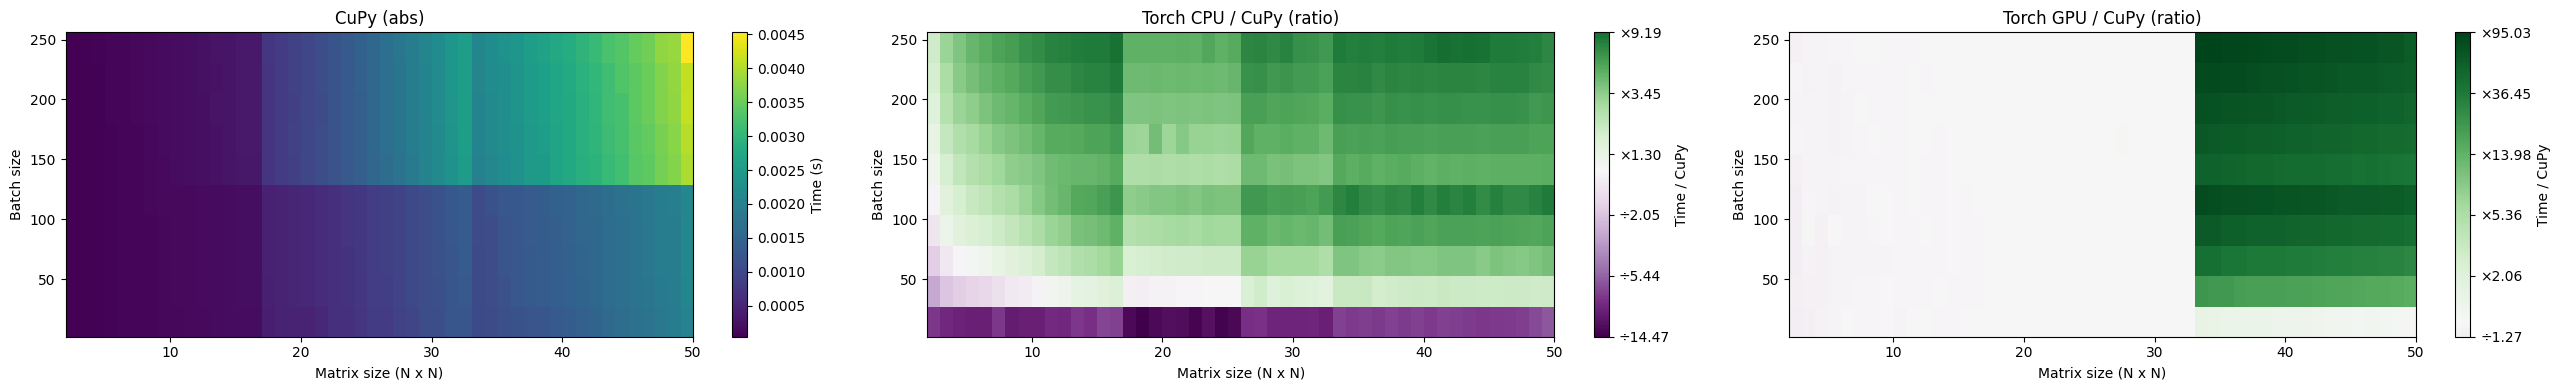

In [127]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# --- Load Results ---
data = pickle.load(open("eigh_benchmark_results_float.pkl", "rb"))
results = data["results"]
matrix_sizes = data["matrix_sizes"][::-1]
batch_sizes = data["batch_sizes"][::-1]

# --- Flip data to increasing order ---
for k in results:
    results[k] = results[k][::-1, ::-1]

# --- Set plot limits ---
matrix_min, matrix_max = 2, 500
batch_min, batch_max = 2, 500

# --- Mask for slicing ---
matrix_mask = (matrix_sizes >= matrix_min) & (matrix_sizes <= matrix_max)
batch_mask = (batch_sizes >= batch_min) & (batch_sizes <= batch_max)

matrix_idx = np.where(matrix_mask)[0]
batch_idx = np.where(batch_mask)[0]

matrix_sizes_plot = matrix_sizes[matrix_idx]
batch_sizes_plot = batch_sizes[batch_idx]

# --- Slice results ---
sliced_results = {
    k: v[np.ix_(batch_idx, matrix_idx)]
    for k, v in results.items()
}

# --- Plotting ---
titles = [
    "CuPy (abs)",
    "Torch CPU / CuPy (ratio)",
    "Torch GPU / CuPy (ratio)"
]
keys = ["cupy_gpu", "torch_cpu", "torch_gpu"]
fig, axes = plt.subplots(1, len(titles), figsize=(26, 4))

base = sliced_results["cupy_gpu"]

for ax, key, title in zip(axes, keys, titles):
    if "abs" in title.lower():
        im = ax.imshow(sliced_results[key], origin="lower", aspect="auto",
                       extent=[matrix_sizes_plot[0], matrix_sizes_plot[-1],
                               batch_sizes_plot[0], batch_sizes_plot[-1]],
                       interpolation="nearest")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Time (s)")

    elif "ratio" in title.lower():
        ratio = sliced_results[key] / base
        log_ratio = np.log10(ratio)

        # Center colormap around 0 (log10(1)), symmetric vmin/vmax
        max_dev = np.nanmax(np.abs(log_ratio))
        vmin = -max_dev
        vmax = max_dev

        im = ax.imshow(log_ratio, origin="lower", aspect="auto",
                    extent=[matrix_sizes_plot[0], matrix_sizes_plot[-1],
                            batch_sizes_plot[0], batch_sizes_plot[-1]],
                    interpolation="nearest", cmap="PRGn", vmin=vmin, vmax=vmax)

        # Get min/max of original ratio values (not log)
        rmin = np.nanmin(ratio)
        rmax = np.nanmax(ratio)

        # Generate log-spaced ticks between rmin and rmax
        n_ticks = 6
        tick_ratios = np.geomspace(rmin, rmax, num=n_ticks)
        tick_vals = np.log10(tick_ratios)
        tick_labels = [f"×{v:.2f}" if v >= 1 else f"÷{1/v:.2f}" for v in tick_ratios]


        cbar = fig.colorbar(im, ax=ax, ticks=tick_vals)
        cbar.ax.set_yticklabels(tick_labels)
        cbar.set_label("Time / CuPy")
        cbar.ax.set_ylim(tick_vals[0], tick_vals[-1])


    else:
        diff = sliced_results[key] - base
        vmax = np.nanmax(np.abs(diff))
        vmin = -vmax
        im = ax.imshow(diff, origin="lower", aspect="auto",
                       extent=[matrix_sizes_plot[0], matrix_sizes_plot[-1],
                               batch_sizes_plot[0], batch_sizes_plot[-1]],
                       interpolation="nearest", cmap="bwr", vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("ΔTime vs CuPy (s)")

    ax.set_title(title)
    ax.set_xlabel("Matrix size (N x N)")
    ax.set_ylabel("Batch size")

plt.tight_layout()
plt.show()


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# --- Load Results ---
data = pickle.load(open("eigh_benchmark_results_big_JAX.pkl", "rb"))
results = data["results"]
matrix_sizes = data["matrix_sizes"][::-1]
batch_sizes = data["batch_sizes"][::-1]

# --- Flip data to increasing order ---
for k in results:
    results[k] = results[k][::-1, ::-1]

# --- Set plot limits ---
matrix_min, matrix_max = 100, 50000
batch_min, batch_max = 2, 100000

# --- Mask for slicing ---
matrix_mask = (matrix_sizes >= matrix_min) & (matrix_sizes <= matrix_max)
batch_mask = (batch_sizes >= batch_min) & (batch_sizes <= batch_max)

matrix_idx = np.where(matrix_mask)[0]
batch_idx = np.where(batch_mask)[0]

matrix_sizes_plot = matrix_sizes[matrix_idx]
batch_sizes_plot = batch_sizes[batch_idx]

# --- Slice results ---
sliced_results = {
    k: v[np.ix_(batch_idx, matrix_idx)]
    for k, v in results.items()
}

# --- Plotting ---
titles = [
    "JAX (abs)",
    "JAX GPU / CuPy (ratio)",
    "CuPy (abs)",

]
keys = ["jax_gpu", "jax_gpu", "cupy_gpu"]
fig, axes = plt.subplots(1, len(titles), figsize=(26, 4))

base = sliced_results["cupy_gpu"]

for ax, key, title in zip(axes, keys, titles):
    if "abs" in title.lower():
        im = ax.imshow(sliced_results[key], origin="lower", aspect="auto",
                       extent=[matrix_sizes_plot[0], matrix_sizes_plot[-1],
                               batch_sizes_plot[0], batch_sizes_plot[-1]],
                       interpolation="nearest")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Time (s)")

    elif "ratio" in title.lower():
        ratio = sliced_results[key] / base
        log_ratio = np.log10(ratio)

        # Center colormap around 0 (log10(1)), symmetric vmin/vmax
        max_dev = np.nanmax(np.abs(log_ratio))
        vmin = -max_dev
        vmax = max_dev

        im = ax.imshow(log_ratio, origin="lower", aspect="auto",
                    extent=[matrix_sizes_plot[0], matrix_sizes_plot[-1],
                            batch_sizes_plot[0], batch_sizes_plot[-1]],
                    interpolation="nearest", cmap="PRGn", vmin=vmin, vmax=vmax)

        # Get min/max of original ratio values (not log)
        rmin = np.nanmin(ratio)
        rmax = np.nanmax(ratio)

        # Generate log-spaced ticks between rmin and rmax
        n_ticks = 6
        tick_ratios = np.geomspace(rmin, rmax, num=n_ticks)
        tick_vals = np.log10(tick_ratios)
        tick_labels = [f"×{v:.2f}" if v >= 1 else f"÷{1/v:.2f}" for v in tick_ratios]


        cbar = fig.colorbar(im, ax=ax, ticks=tick_vals)
        cbar.ax.set_yticklabels(tick_labels)
        cbar.set_label("Time / CuPy")
        cbar.ax.set_ylim(tick_vals[0], tick_vals[-1])


    else:
        diff = sliced_results[key] - base
        vmax = np.nanmax(np.abs(diff))
        vmin = -vmax
        im = ax.imshow(diff, origin="lower", aspect="auto",
                       extent=[matrix_sizes_plot[0], matrix_sizes_plot[-1],
                               batch_sizes_plot[0], batch_sizes_plot[-1]],
                       interpolation="nearest", cmap="bwr", vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("ΔTime vs CuPy (s)")

    ax.set_title(title)
    ax.set_xlabel("Matrix size (N x N)")
    ax.set_ylabel("Batch size")

plt.tight_layout()
plt.show()


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# --- Load Results ---
data = pickle.load(open("eigh_benchmark_results_full.pkl", "rb"))
results = data["results"]
matrix_sizes = data["matrix_sizes"][::-1]
batch_sizes = data["batch_sizes"][::-1]

# --- Flip data to increasing order ---
for k in results:
    results[k] = results[k][::-1, ::-1]

# --- Set plot limits ---
matrix_min, matrix_max = 500, 50000
batch_min, batch_max = 2, 100000

# --- Mask for slicing ---
matrix_mask = (matrix_sizes >= matrix_min) & (matrix_sizes <= matrix_max)
batch_mask = (batch_sizes >= batch_min) & (batch_sizes <= batch_max)

matrix_idx = np.where(matrix_mask)[0]
batch_idx = np.where(batch_mask)[0]

matrix_sizes_plot = matrix_sizes[matrix_idx]
batch_sizes_plot = batch_sizes[batch_idx]

# --- Slice results ---
sliced_results = {
    k: v[np.ix_(batch_idx, matrix_idx)]
    for k, v in results.items()
}

# --- Plotting ---
titles = [
    "JAX (abs)",
    # "Cupy / JAX (ratio)",
    "Torch GPU / JAX (ratio)",
]
keys = ["jax_gpu", "torch_gpu"]
fig, axes = plt.subplots(1, len(titles), figsize=(26, 4))

base = sliced_results["jax_gpu"]

for ax, key, title in zip(axes, keys, titles):
    if "abs" in title.lower():
        im = ax.imshow(sliced_results[key], origin="lower", aspect="auto",
                       extent=[matrix_sizes_plot[0], matrix_sizes_plot[-1],
                               batch_sizes_plot[0], batch_sizes_plot[-1]],
                       interpolation="nearest")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Time (s)")

    elif "ratio" in title.lower():
        ratio = sliced_results[key] / base
        log_ratio = np.log10(ratio)

        # Center colormap around 0 (log10(1)), symmetric vmin/vmax
        max_dev = np.nanmax(np.abs(log_ratio))
        vmin = -max_dev
        vmax = max_dev

        im = ax.imshow(log_ratio, origin="lower", aspect="auto",
                    extent=[matrix_sizes_plot[0], matrix_sizes_plot[-1],
                            batch_sizes_plot[0], batch_sizes_plot[-1]],
                    interpolation="nearest", cmap="PRGn", vmin=vmin, vmax=vmax)

        # Get min/max of original ratio values (not log)
        rmin = np.nanmin(ratio)
        rmax = np.nanmax(ratio)

        # Generate log-spaced ticks between rmin and rmax
        n_ticks = 6
        tick_ratios = np.geomspace(rmin, rmax, num=n_ticks)
        tick_vals = np.log10(tick_ratios)
        tick_labels = [f"×{v:.2f}" if v >= 1 else f"÷{1/v:.2f}" for v in tick_ratios]


        cbar = fig.colorbar(im, ax=ax, ticks=tick_vals)
        cbar.ax.set_yticklabels(tick_labels)
        cbar.set_label("Time / CuPy")
        cbar.ax.set_ylim(tick_vals[0], tick_vals[-1])


    else:
        diff = sliced_results[key] - base
        vmax = np.nanmax(np.abs(diff))
        vmin = -vmax
        im = ax.imshow(diff, origin="lower", aspect="auto",
                       extent=[matrix_sizes_plot[0], matrix_sizes_plot[-1],
                               batch_sizes_plot[0], batch_sizes_plot[-1]],
                       interpolation="nearest", cmap="bwr", vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("ΔTime vs CuPy (s)")

    ax.set_title(title)
    ax.set_xlabel("Matrix size (N x N)")
    ax.set_ylabel("Batch size")

plt.tight_layout()
plt.show()


In [ ]:
import pickle
results = pickle.load(open("eigh_benchmark_results_full.pkl", "rb"))["results"]
matrix_sizes = pickle.load(open("eigh_benchmark_results_full.pkl", "rb"))["matrix_sizes"][::-1]
batch_sizes = pickle.load(open("eigh_benchmark_results_full.pkl", "rb"))["batch_sizes"][::-1]

for k, v in results.items():
    print(f"{k}: {v.shape}")
    results[k] = results[k][::-1, ::-1]  

    

# --- Plotting (1): baseline = torch_cpu ---
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
titles = ["NumPy - Torch CPU", "Torch CPU (abs)", "Torch GPU - CPU", "JAX CPU - Torch CPU", "JAX GPU - Torch CPU", ]
keys = ["numpy_cpu", "torch_cpu", "torch_gpu", "jax_cpu", "jax_gpu", ]
base = results["torch_cpu"]

for ax, key, title in zip(axes, keys, titles):
    if "abs" in title:
        im = ax.imshow(results[key], origin="lower", aspect="auto",
                       extent=[matrix_sizes[0], matrix_sizes[-1], batch_sizes[0], batch_sizes[-1]],
                       interpolation="nearest")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Time (s)")
    else:
        diff = results[key] - base
        vmax = np.nanmax(np.abs(diff))
        vmin = -vmax
        im = ax.imshow(diff, origin="lower", aspect="auto",
                       extent=[matrix_sizes[0], matrix_sizes[-1], batch_sizes[0], batch_sizes[-1]],
                       interpolation="nearest", cmap="bwr", vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("\u0394Time vs Torch CPU (s)")
    ax.set_title(title)
    ax.set_xlabel("Matrix size (N x N)")
    ax.set_ylabel("Batch size")

plt.tight_layout()
plt.show()

# --- Plotting (2): baseline = jax_gpu ---
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
titles = ["NumPy - JAX GPU", "Torch CPU - JAX GPU", "Torch GPU - JAX GPU", "JAX CPU - JAX GPU", "JAX GPU (abs)"]
keys = ["numpy_cpu", "torch_cpu", "torch_gpu", "jax_cpu", "jax_gpu"]
base = results["jax_gpu"]

for ax, key, title in zip(axes, keys, titles):
    if "abs" in title:
        im = ax.imshow(results[key], origin="lower", aspect="auto",
                       extent=[matrix_sizes[0], matrix_sizes[-1], batch_sizes[0], batch_sizes[-1]],
                       interpolation="nearest")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Time (s)")
    else:
        diff = results[key] - base
        vmax = np.nanmax(np.abs(diff))
        vmin = -vmax
        im = ax.imshow(diff, origin="lower", aspect="auto",
                       extent=[matrix_sizes[0], matrix_sizes[-1], batch_sizes[0], batch_sizes[-1]],
                       interpolation="nearest", cmap="bwr", vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("\u0394Time vs JAX GPU (s)")
    ax.set_title(title)
    ax.set_xlabel("Matrix size (N x N)")
    ax.set_ylabel("Batch size")

plt.tight_layout()
plt.show()


# Testing

In [ ]:
import time
import numpy as np
import torch
import jax
import jax.numpy as jnp

# Parameters
B, N = 200, 1000

def symmetrize(x):
    return (x + x.transpose(-1, -2)) / 2

def symmetrize_jax(x):
    return (x + jnp.transpose(x, axes=(0, 2, 1))) / 2

# Generate random matrices
np.random.seed(0)
data_np = np.random.randn(B, N, N).astype(np.float32)

In [ ]:
res = np.linalg.eigh(data_np)
# print the shapes
print(res[0].shape, res[1].shape)

In [ ]:
from functorch import vmap

def eigh_fn(mat):
    return torch.linalg.eigh(mat)

batched_eigh = vmap(eigh_fn)

print("Matrix shape:", data_np.shape)
# PyTorch CPU
x_t_cpu = symmetrize(torch.tensor(data_np))
start = time.time()
# torch_eigvals_cpu, torch_eigvecs_cpu = torch.linalg.eigh(x_t_cpu)
torch_eigvals_cpu, torch_eigvecs_cpu = batched_eigh(x_t_cpu)
print("PyTorch CPU:", time.time() - start, "s")

# PyTorch GPU
if torch.cuda.is_available():
    x_t_gpu = symmetrize(torch.tensor(data_np, device='cuda'))
    torch.cuda.synchronize()
    start = time.time()
    # torch_eigvals_gpu, torch_eigvecs_gpu = torch.linalg.eigh(x_t_gpu)
    torch_eigvals_gpu, torch_eigvecs_gpu = batched_eigh(x_t_gpu)
    torch.cuda.synchronize()
    print("PyTorch GPU:", time.time() - start, "s")
else:
    print("PyTorch GPU: CUDA not available")

@jax.jit
def batched_eigh(x):
    return jax.vmap(jnp.linalg.eigh)(x)

# JAX CPU
x_j_cpu = symmetrize_jax(jnp.array(data_np))
eigvals_jax_cpu, eigvecs_jax_cpu = batched_eigh(x_j_cpu)  # compile warm-up
eigvals_jax_cpu.block_until_ready()

start = time.time()
eigvals_jax_cpu, eigvecs_jax_cpu = batched_eigh(x_j_cpu)
eigvals_jax_cpu.block_until_ready()
print("JAX CPU:", time.time() - start, "s")

# JAX GPU
if any(d.platform == 'gpu' for d in jax.devices()):
    x_j_gpu = symmetrize_jax(jax.device_put(data_np, device=jax.devices("gpu")[0]))
    eigvals_jax_gpu, eigvecs_jax_gpu = batched_eigh(x_j_gpu)
    eigvals_jax_gpu.block_until_ready()

    start = time.time()
    eigvals_jax_gpu, eigvecs_jax_gpu = batched_eigh(x_j_gpu)
    eigvals_jax_gpu.block_until_ready()
    print("JAX GPU:", time.time() - start, "s")
else:
    print("JAX GPU: GPU backend not available")


In [ ]:
import time
import numpy as np
import torch
import jax
import jax.numpy as jnp

# Parameters
B, N = 20, 500
np.random.seed(0)
data_np = np.random.randn(B, N, N).astype(np.float32)

def symmetrize(x):
    return (x + x.transpose(-1, -2)) / 2

def symmetrize_jax(x):
    return (x + jnp.transpose(x, axes=(0, 2, 1))) / 2

# --- NumPy batched eigh ---
def numpy_benchmark(x, runs=10):
    x = symmetrize(x)

    start = time.time()
    for _ in range(runs):
        np.linalg.eigh(x)
    avg_time = (time.time() - start) / runs
    return avg_time

# --- PyTorch batched eigh via functorch ---
def torch_benchmark(x, device="cpu", runs=10):
    x = symmetrize(torch.tensor(data_np, device=device))

    # Warm-up
    vals, vecs = torch.linalg.eigh(x)
    if device == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    for _ in range(runs):
        vals, vecs = torch.linalg.eigh(x)
        if device == "cuda":
            torch.cuda.synchronize()
    avg_time = (time.time() - start) / runs
    return avg_time

# --- JAX batched eigh ---
@jax.jit
def batched_eigh_jax(x):
    return jax.vmap(jnp.linalg.eigh)(x)

def jax_benchmark(x, runs=10):
    vals, vecs = batched_eigh_jax(x)
    vals.block_until_ready()  # warm-up

    start = time.time()
    for _ in range(runs):
        vals, vecs = batched_eigh_jax(x)
        vals.block_until_ready()
    avg_time = (time.time() - start) / runs
    return avg_time

# --- Run all benchmarks ---
print(f"Matrix shape: {data_np.shape}")

cpu_time_torch = torch_benchmark(data_np, device="cpu")
print(f"PyTorch CPU avg: {cpu_time_torch:.4f} s")

if torch.cuda.is_available():
    gpu_time_torch = torch_benchmark(data_np, device="cuda")
    print(f"PyTorch GPU avg: {gpu_time_torch:.4f} s")
else:
    print("PyTorch GPU: CUDA not available")

x_j_cpu = symmetrize_jax(jnp.array(data_np))
cpu_time_jax = jax_benchmark(x_j_cpu)
print(f"JAX CPU avg: {cpu_time_jax:.4f} s")

if any(d.platform == "gpu" for d in jax.devices()):
    
    gpu_time_jax = jax_benchmark(x_j_gpu)
    print(f"JAX GPU avg: {gpu_time_jax:.4f} s")
else:
    print("JAX GPU: GPU backend not available")


In [ ]:
import time
import numpy as np
import torch
import jax
import jax.numpy as jnp

# Parameters
B, N = 64, 50
runs = 10
np.random.seed(0)
data_np = np.random.randn(B, N, N).astype(np.float32)

def symmetrize(x):
    if isinstance(x, np.ndarray):
        return (x + x.transpose(0, 2, 1)) / 2
    elif isinstance(x, torch.Tensor):
        return (x + x.transpose(-1, -2)) / 2
    else:
        return (x + jnp.transpose(x, axes=(0, 2, 1))) / 2

# --- NumPy benchmark ---
def benchmark_numpy(x, runs):
    x = symmetrize(x)
    _ = np.linalg.eigh(x)   # warm-up
    start = time.time()
    for _ in range(runs):
        _ = np.linalg.eigh(x)
    return (time.time() - start) / runs

# --- PyTorch benchmark ---
def benchmark_torch(x_np, device, runs):
    x = symmetrize(torch.tensor(x_np, device=device))
    _ = torch.linalg.eigh(x)  # warm-up
    if device == "cuda":
        torch.cuda.synchronize()
    start = time.time()
    for _ in range(runs):
        _ = torch.linalg.eigh(x)
        if device == "cuda":
            torch.cuda.synchronize()
    return (time.time() - start) / runs

# --- JAX benchmark ---
@jax.jit
def batched_eigh_jax(x):
    return jax.vmap(jnp.linalg.eigh)(x)

def benchmark_jax(x_np, device, runs):
    x = symmetrize(jax.device_put(x_np, device=device))
    _ = batched_eigh_jax(x)  # warm-up
    jax.block_until_ready(_)
    start = time.time()
    for _ in range(runs):
        result = batched_eigh_jax(x)
        jax.block_until_ready(result)
    return (time.time() - start) / runs

# --- Run all benchmarks ---
print(f"Benchmarking batched diagonalization on shape: ({B}, {N}, {N})")

# NumPy (CPU only)
time_np = benchmark_numpy(data_np, runs)
print(f"NumPy CPU avg:    {time_np:.4f} s")

# PyTorch CPU
time_torch_cpu = benchmark_torch(data_np, device="cpu", runs=runs)
print(f"PyTorch CPU avg:  {time_torch_cpu:.4f} s")

# PyTorch GPU (if available)
if torch.cuda.is_available():
    time_torch_gpu = benchmark_torch(data_np, device="cuda", runs=runs)
    print(f"PyTorch GPU avg:  {time_torch_gpu:.4f} s")
else:
    print("PyTorch GPU:      CUDA not available")

# JAX CPU
time_jax_cpu = benchmark_jax(data_np, jax.devices("cpu")[0], runs)
print(f"JAX CPU avg:      {time_jax_cpu:.4f} s")

# JAX GPU (if available)
jax_gpu_devices = [d for d in jax.devices() if d.platform == "gpu"]
if jax_gpu_devices:
    time_jax_gpu = benchmark_jax(data_np, jax_gpu_devices[0], runs)
    print(f"JAX GPU avg:      {time_jax_gpu:.4f} s")
else:
    print("JAX GPU:          GPU backend not available")


# 3D Plot

In [ ]:
import time
import numpy as np
import torch
from functorch import vmap
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

# Define symmetrization and benchmark functions
def symmetrize(x):
    return (x + x.transpose(-1, -2)) / 2

def symmetrize_jax(x):
    return (x + jnp.transpose(x, axes=(0, 2, 1))) / 2

# --- PyTorch batched eigh via functorch ---
def torch_benchmark(x_np, device="cpu", runs=10):
    x = symmetrize(torch.tensor(x_np, device=device))
    eig_fn = vmap(torch.linalg.eigh)
    vals, vecs = eig_fn(x)
    if device == "cuda":
        torch.cuda.synchronize()
    start = time.time()
    for _ in range(runs):
        vals, vecs = eig_fn(x)
        if device == "cuda":
            torch.cuda.synchronize()
    return (time.time() - start) / runs

# --- JAX batched eigh ---
@jax.jit
def batched_eigh_jax(x):
    return jax.vmap(jnp.linalg.eigh)(x)

def jax_benchmark(x_np, device="cpu", runs=10):
    x = jnp.array(x_np) if device == "cpu" else jax.device_put(x_np, device=jax.devices("gpu")[0])
    x = symmetrize_jax(x)
    vals, vecs = batched_eigh_jax(x)
    vals.block_until_ready()
    start = time.time()
    for _ in range(runs):
        vals, vecs = batched_eigh_jax(x)
        vals.block_until_ready()
    return (time.time() - start) / runs

# Grid setup
batch_sizes = np.linspace(2, 100, 10, dtype=int)
matrix_sizes = np.linspace(10, 500, 10, dtype=int)

# Result storage
results = {
    "torch_cpu": np.zeros((len(batch_sizes), len(matrix_sizes))),
    "torch_gpu": np.zeros((len(batch_sizes), len(matrix_sizes))),
    "jax_cpu": np.zeros((len(batch_sizes), len(matrix_sizes))),
    "jax_gpu": np.zeros((len(batch_sizes), len(matrix_sizes))),
}

# Benchmark loop
for i, B in tqdm(enumerate(batch_sizes)):
    for j, N in enumerate(matrix_sizes):
        np.random.seed(0)
        data_np = np.random.randn(B, N, N).astype(np.float32)
        data_np = 0.5 * (data_np + np.transpose(data_np, (0, 2, 1)))

        results["torch_cpu"][i, j] = torch_benchmark(data_np, device="cpu")
        results["jax_cpu"][i, j] = jax_benchmark(data_np, device="cpu")

        if torch.cuda.is_available():
            results["torch_gpu"][i, j] = torch_benchmark(data_np, device="cuda")
        else:
            results["torch_gpu"][i, j] = np.nan

        if any(d.platform == "gpu" for d in jax.devices()):
            results["jax_gpu"][i, j] = jax_benchmark(data_np, device="gpu")
        else:
            results["jax_gpu"][i, j] = np.nan

# Save timings
with open("eigh_benchmark_results.pkl", "wb") as f:
    pickle.dump({"batch_sizes": batch_sizes, "matrix_sizes": matrix_sizes, "results": results}, f)


In [ ]:
# Plotting with baseline subtraction and diverging colormap
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
titles = ["PyTorch CPU", "PyTorch GPU - CPU", "JAX CPU - CPU", "JAX GPU - CPU"]
keys = ["torch_cpu", "torch_gpu", "jax_cpu", "jax_gpu"]

# Compute differences (relative to torch_cpu)
diff_results = {
    "torch_cpu": results["torch_cpu"],
    "torch_gpu": results["torch_gpu"] - results["torch_cpu"],
    "jax_cpu": results["jax_cpu"] - results["torch_cpu"],
    "jax_gpu": results["jax_gpu"] - results["torch_cpu"],
}

# Common scale for all diff plots
diff_data = np.array([diff_results[k] for k in keys[1:]])  # exclude baseline
vmax = np.nanmax(np.abs(diff_data))
vmin = -vmax

for ax, key, title in zip(axes.ravel(), keys, titles):
    if key == "torch_cpu":
        im = ax.imshow(results[key], origin="lower", aspect="auto",
                       extent=[matrix_sizes[0], matrix_sizes[-1], batch_sizes[0], batch_sizes[-1]],
                       interpolation="nearest")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Time (seconds)")
    else:
        im = ax.imshow(diff_results[key], origin="lower", aspect="auto",
                       extent=[matrix_sizes[0], matrix_sizes[-1], batch_sizes[0], batch_sizes[-1]],
                       interpolation="nearest", cmap="bwr", vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("ΔTime vs PyTorch CPU (s)")
    ax.set_title(title)
    ax.set_xlabel("Matrix size (N×N)")
    ax.set_ylabel("Batch size")

plt.tight_layout()
plt.show()


In [ ]:
# Plotting: JAX GPU as baseline, each subplot with its own colorbar
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
titles = ["PyTorch CPU - JAX GPU", "PyTorch GPU - JAX GPU", "JAX CPU - JAX GPU", "JAX GPU (absolute)"]
keys = ["torch_cpu", "torch_gpu", "jax_cpu", "jax_gpu"]

# Compute difference maps relative to JAX GPU
diff_results = {
    "torch_cpu": results["torch_cpu"] - results["jax_gpu"],
    "torch_gpu": results["torch_gpu"] - results["jax_gpu"],
    "jax_cpu": results["jax_cpu"] - results["jax_gpu"],
    "jax_gpu": results["jax_gpu"],  # keep as absolute
}

# Plot each
for ax, key, title in zip(axes.ravel(), keys, titles):
    if key == "jax_gpu":
        im = ax.imshow(results[key], origin="lower", aspect="auto",
                       extent=[matrix_sizes[0], matrix_sizes[-1], batch_sizes[0], batch_sizes[-1]],
                       interpolation="nearest")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Time (seconds)")
    else:
        diff = diff_results[key]
        vmax = np.nanmax(np.abs(diff))
        vmin = -vmax
        im = ax.imshow(diff, origin="lower", aspect="auto",
                       extent=[matrix_sizes[0], matrix_sizes[-1], batch_sizes[0], batch_sizes[-1]],
                       interpolation="nearest", cmap="bwr", vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("ΔTime vs JAX GPU (s)")
    ax.set_title(title)
    ax.set_xlabel("Matrix size (N×N)")
    ax.set_ylabel("Batch size")

plt.tight_layout()
plt.show()
